In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import SimpleITK as sitk
import matplotlib.pyplot as plt 

In [6]:
seg_p="/kaggle/input/penguin/PENGWIN_labels/002.mha"
im_p ="/kaggle/input/penguin/PENGWIN_images/002.mha"

seg = sitk.ReadImage(seg_p, sitk.sitkInt16)
im = sitk.ReadImage(im_p, sitk.sitkInt16)

seg_a = sitk.GetArrayFromImage(seg)
im_a = sitk.GetArrayFromImage(im)

seg_tensor = torch.from_numpy(seg_a)
im_tensor=torch.from_numpy(im_a).to(device)
print(seg_tensor.shape)
seg_tensor = seg_tensor[:,:,:]
im_tensor  = im_tensor[:,:,:]

 
# img_slices = torch.stack([pad_torch(normalize_slice(img_slice), 512, 512) for img_slice in im_tensor]) 

# initial_shapes=  (seg_tensor.shape[1] , seg_tensor.shape[2])

# img_slices = img_slices.unsqueeze(1).float()  

# print(seg_tensor.shape , img_slices.shape)
print(im_tensor.shape)

torch.Size([337, 276, 413])
torch.Size([337, 276, 413])


In [ ]:
label=seg_tensor[0,:,:].detach().cpu()
plt.imshow(label)
print(np.unique(label , return_counts=True))

In [2]:
import os

weights="/kaggle/working/epoch425-loss0.0155.pth"
print(f"File size: {os.path.getsize(weights) if os.path.exists(weights) else 'N/A'}")


model = UNet(in_channels=1, out_channels=30).to(device)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(weights))

File size: 124271474


<All keys matched successfully>

In [4]:
final_l = []
array=im_tensor
for i in range(array.shape[0]):
    a, b = array.shape[1], array.shape[2]
    final_img = pad_torch(torch.tensor(array[i, :, :]), 512, 512).unsqueeze(0).unsqueeze(1)
    with torch.no_grad():
        final_pred = model(final_img.to(device))
        final_pred = torch.argmax(final_pred, dim=1)
        final_l.append(unpad(final_pred.squeeze(0), a, b))
final = torch.stack(final_l, dim=0)
print(final.shape)

/tmp/ipykernel_35/3585971000.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_img = pad_torch(torch.tensor(array[i, :, :]), 512, 512).unsqueeze(0).unsqueeze(1)


torch.Size([337, 276, 413])


In [ ]:
two=reshaped_slices[0,:,:].detach().cpu()
print(two.shape)
plt.imshow(two)
print(np.unique(two,return_counts=True) )


# GROUND TRUTH VIEWS PLOTS 

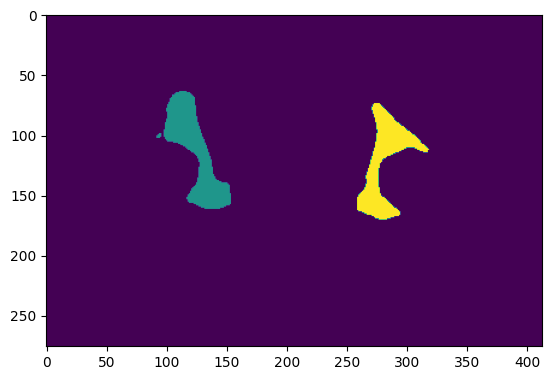

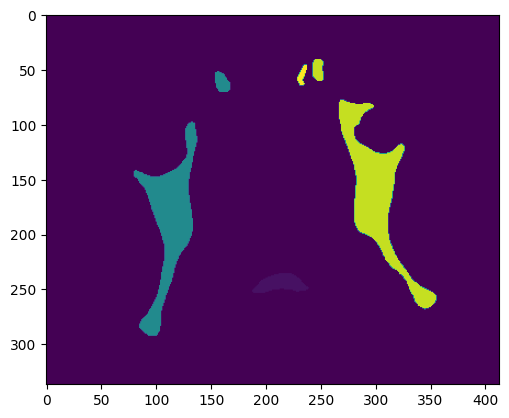

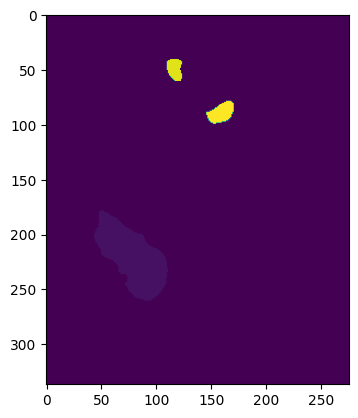

In [7]:
plt.imshow(seg_tensor[110,:,:])   # axial  one slice
plt.show()
plt.imshow(seg_tensor[:,120,:])  # coronal one slice
plt.show()
plt.imshow(seg_tensor[:,:,250])  # sagittal one slice
plt.show()


# PREDICTIONS VIEWS PLOTS 

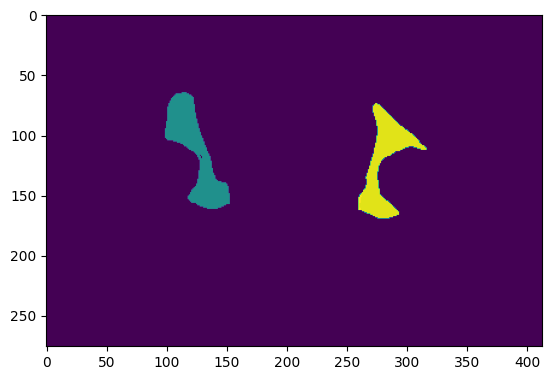

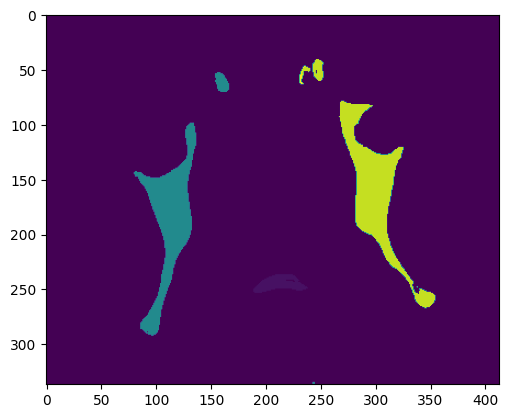

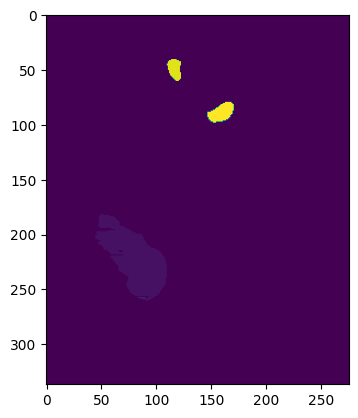

In [8]:
outputs=final.detach().cpu().numpy()
plt.imshow(outputs[110,:,:])    # axial  one slice
plt.show()
plt.imshow(outputs[:,120,:])   
plt.show()
plt.imshow(outputs[:,:,250])
plt.show()


In [ ]:
one=predicted_mask[0,:,:].detach().cpu()
print(one.shape)
print(np.unique(one,return_counts=True) )
plt.imshow(one)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=30):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        def upconv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = upconv_block(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        
        self.upconv3 = upconv_block(512, 256)
        self.decoder3 = conv_block(512, 256)
        
        self.upconv2 = upconv_block(256, 128)
        self.decoder2 = conv_block(256, 128)
        
        self.upconv1 = upconv_block(128, 64)
        self.decoder1 = conv_block(128, 64)
        
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        output = self.output_conv(dec1)
        return output


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
class PenguinDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = sorted(os.listdir(self.image_dir))[1:2]
        self.mask_list  = sorted(os.listdir(self.mask_dir))[1:2]
        
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_list[index])
        mask_path = os.path.join(self.mask_dir, self.mask_list[index])
        
        image = sitk.ReadImage(img_path, sitk.sitkInt16)
        mask = sitk.ReadImage(mask_path, sitk.sitkInt16)       
        
        img = sitk.GetArrayFromImage(image)
        ms = sitk.GetArrayFromImage(mask)
  
        img_tensor = torch.from_numpy(img).to(device)
        mask_tensor = torch.from_numpy(ms).to(device)
        
        return img_tensor, mask_tensor

    def __len__(self):
        return len(self.image_list)

In [ ]:
def unpad(x , a,b):
    r,c=np.shape(x)
    start=(r-a)//2
    end=(c-b)//2
    return x[ start: start+a , end:end+b]
def pad_torch(x, a, b):
    r, c = x.shape  # Get the last two dimensions
    temp = torch.zeros((a, b), device=x.device)
    r_start = (a - r) // 2
    c_start = (b - c) // 2
    temp[r_start:r_start+r, c_start:c_start+c] = x
    return temp
def percentage(mask):
    return (np.sum(mask > 0) / mask.size) * 100


In [ ]:
def normalize_slice(slice, min_val=-350, max_val=350):
    slice_clamped = torch.clamp(slice, min=min_val, max=max_val)
    
    slice_normalized = (slice_clamped - min_val) / (max_val - min_val)
    
    return slice_normalized * (max_val - min_val) + min_val


In [ ]:
def epochnum(file):
    try:
        epoch_part = file.split('epoch')[1].split('-')[0]
        return int(epoch_part)
    except (IndexError, ValueError):
        return -1


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

penguin_data = PenguinDataset("/kaggle/input/penguin/PENGWIN_images", "/kaggle/input/penguin/PENGWIN_labels")
penguin_dataloader = DataLoader(penguin_data, batch_size=1, shuffle=True)

model = UNet(in_channels=1, out_channels=30).to(device)
model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()

optim = torch.optim.Adam(model.parameters(), lr=2e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.2, patience=2, verbose=True)


In [ ]:
for x , y in penguin_dataloader:
    print(x.shape , y.shape)

In [ ]:
def train_axial(model, optim, criterion, dataloader, epochs, device, start_epoch, num_slices, tol):
    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):
        epoch_loss = 0.0
        num_examples = 0
        c=0
        
        for img, msk in dataloader:
            volume_loss = 0
            num = img.shape[1]  # Changed to shape[1] for axial
            l = []
            start, end = None, None
            
            for i in range(num):
                t = msk[:,i,:,:]  # Changed indexing for axial
                l.append(percentage(np.array(t.cpu()).squeeze(0)))
            for i in range(len(l)-1):
                if l[i+1] > 0:
                    start = i+1
                    break
            for j in range(len(l)):
                if l[-j-1] > 0:
                    end = len(l)-j-1
                    break
            
            for i in range(start-tol, end+tol, num_slices):
                image = img[:, i:i+num_slices, :, :]  # Changed indexing for axial
                mask = msk[:, i:i+num_slices, :, :]
                
                final_images = torch.stack([pad_torch(normalize_slice(img_slice), 512, 512) for img_slice in image.squeeze(0)])
                final_masks = torch.stack([pad_torch(msk_slice, 512, 512) for msk_slice in mask.squeeze(0)])
                
                final_images = final_images.unsqueeze(1).float()
                final_masks= final_masks.long()
                
                out = model(final_images)
    
                loss = criterion(out, final_masks)

                volume_loss += loss.item()
                optim.zero_grad()
                loss.backward()
                optim.step()
                c+=num_slices
                
            epoch_loss += volume_loss
        scheduler.step(epoch_loss)

        
        print(f"epoch {epoch}, loss {epoch_loss:.4f}, avg volume loss {epoch_loss/c:.4f}")
        if epoch % 5 == 0:
            model_filename = f"epoch{epoch}-loss{epoch_loss:.4f}.pth"
            model_path = os.path.join("/kaggle/working", model_filename)
            torch.save(model.state_dict(), model_path)
            print(f"Model saved: {model_path}")

In [ ]:
path = "/kaggle/working"
pth_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith('.pth')]
pth_files.sort(key=lambda x: epochnum(os.path.join(path, x)) , reverse=True)
# print(pth_files)
if len(pth_files)>0:
    state= pth_files[0]
else:
    state=None

if state:
    weights = os.path.join(path, state)
    print(f"Resuming from checkpoint: {state}")
    print(f"Loading weights from: {state}")
    model.load_state_dict(torch.load(weights))
    start_epoch = epochnum(state)
else:
    print("No checkpoint found. Starting from scratch.")
    start_epoch = 0

print(f"Starting from epoch: {start_epoch}")

epochs=70
num_slices=14
train_axial(model, optim, criterion, penguin_dataloader, epochs=epochs, device=device, start_epoch=start_epoch , num_slices=num_slices , tol=-5)

In [ ]:
path = "/kaggle/working"
pth_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith('.pth')]
pth_files.sort(key=lambda x: epochnum(os.path.join(path, x)) , reverse=True)
for file in pth_files[1:]:
    os.remove(os.path.join(path , file))
    print(f"removed {file}")
print(pth_files[1])

In [ ]:
print(os.listdir(path))


In [ ]:
!nvidia-smi
# !nvidia-smi --gpu-reset

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = cuda.get_current_device()
print(device)
device.reset()